In [1]:
# Install required libraries
!pip install -q transformers datasets peft accelerate matplotlib scikit-learn


In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from transformers import AutoImageProcessor, AutoModelForImageClassification
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Initialize accelerator for efficient training
accelerator = Accelerator()
print(f"Using device: {accelerator.device}")


Using device: cuda


In [4]:
# Load CIFAR-10 dataset with appropriate transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Swin expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Train samples: 50000, Test samples: 10000


In [5]:
# Load pre-trained Swin Transformer model
model_name = "microsoft/swin-tiny-patch4-window7-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=10,  # CIFAR-10 has 10 classes
    ignore_mismatched_sizes=True  # Allow different classifier head
)

print("Swin Transformer loaded successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swin Transformer loaded successfully!


In [6]:
# Define LoRA configuration for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=16,  # Rank of LoRA matrices
    lora_alpha=32,  # Scaling factor
    target_modules=["query", "key", "value"],  # Apply to attention layers
    lora_dropout=0.05,  # Dropout for LoRA layers
    bias="none",  # No bias in LoRA
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Show how many parameters are trainable

trainable params: 423,936 || all params: 27,950,980 || trainable%: 1.5167


In [7]:
# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Prepare everything with accelerator
model, optimizer, train_loader, test_loader = accelerator.prepare(
    model, optimizer, train_loader, test_loader
)

print("Training setup complete!")

Training setup complete!


In [8]:
# Training loop
model.train()
for epoch in range(3):  # Train for 3 epochs
    total_loss = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)

        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/3 | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed | Average Loss: {total_loss/len(train_loader):.4f}')

print("Training completed!")

Epoch 1/3 | Batch 0/1563 | Loss: 2.4279
Epoch 1/3 | Batch 100/1563 | Loss: 0.5696
Epoch 1/3 | Batch 200/1563 | Loss: 0.4043
Epoch 1/3 | Batch 300/1563 | Loss: 0.4624
Epoch 1/3 | Batch 400/1563 | Loss: 0.2265
Epoch 1/3 | Batch 500/1563 | Loss: 0.4096
Epoch 1/3 | Batch 600/1563 | Loss: 0.2908
Epoch 1/3 | Batch 700/1563 | Loss: 0.2908
Epoch 1/3 | Batch 800/1563 | Loss: 0.2317
Epoch 1/3 | Batch 900/1563 | Loss: 0.2775
Epoch 1/3 | Batch 1000/1563 | Loss: 0.2140
Epoch 1/3 | Batch 1100/1563 | Loss: 0.1453
Epoch 1/3 | Batch 1200/1563 | Loss: 0.2683
Epoch 1/3 | Batch 1300/1563 | Loss: 0.2545
Epoch 1/3 | Batch 1400/1563 | Loss: 0.1408
Epoch 1/3 | Batch 1500/1563 | Loss: 0.1725
Epoch 1 completed | Average Loss: 0.3421
Epoch 2/3 | Batch 0/1563 | Loss: 0.1468
Epoch 2/3 | Batch 100/1563 | Loss: 0.2968
Epoch 2/3 | Batch 200/1563 | Loss: 0.1009
Epoch 2/3 | Batch 300/1563 | Loss: 0.2145
Epoch 2/3 | Batch 400/1563 | Loss: 0.0293
Epoch 2/3 | Batch 500/1563 | Loss: 0.1932
Epoch 2/3 | Batch 600/1563 | Loss

In [9]:
# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        # Gather predictions from all devices
        all_preds.extend(accelerator.gather(preds).cpu().numpy())
        all_labels.extend(accelerator.gather(labels).cpu().numpy())

print("Evaluation completed!")

Evaluation completed!


In [13]:
# Calculate performance metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall: .4f}")
print(f"Precision: {precision:.4f}")
print("\nConfusion Matrix:")
print(cm)


Accuracy: 0.9638
F1 Score: 0.9639
Recall:  0.9638
Precision: 0.9643

Confusion Matrix:
[[974   1   2   1   0   0   0   1  17   4]
 [  0 985   0   0   0   0   0   0   2  13]
 [ 10   0 946  14   8   3  17   1   1   0]
 [  0   1   1 945   5  35  10   2   1   0]
 [  2   0   5  20 961   6   2   4   0   0]
 [  0   0   1  67   4 922   1   5   0   0]
 [  4   0   0   3   0   1 992   0   0   0]
 [  2   0   2   7  20   7   0 962   0   0]
 [  8   6   0   0   0   0   0   0 982   4]
 [  2  26   0   0   0   0   0   0   3 969]]


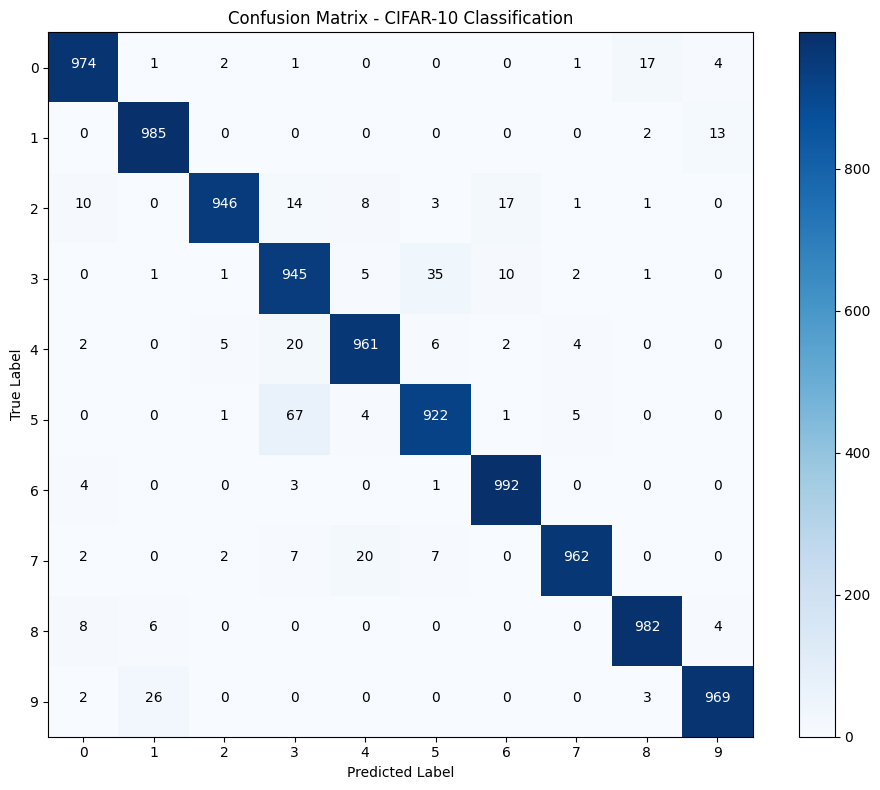

In [11]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CIFAR-10 Classification')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()